In [ ]:
# DREW: This will download the kaggle data from my personal google drive into the colab. 
# Please don't delete or change anything in my drive while it's mounted!!
# IF the code mounts it to your personal google drive, you need to go to kaggle.com and go to your account tab,
# then click make new token, and move the json file it gives you into your google drive. This wil let you download the dataset
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ # make sure youre using the right path to the kaggle.json file
!pip install kaggle
!kaggle competitions download -c store-sales-time-series-forecasting
!unzip store-sales-time-series-forecasting.zip


Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 65% 14.0M/21.4M [00:00<00:00, 141MB/s]
100% 21.4M/21.4M [00:00<00:00, 169MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


#Store Forecasting

###This is the notebook for our store forecasting final project. Don't forget to `!pip install` any packages you need. 

The overall goal is to forecast unit sales in these chains of stores. For each `id` in the test set, we must predict a value for the `sales` variable. The file should contain a header and have the following format:

 We should store the data as a `pd.DataFrame` to easily get the csv. pandas also supports a `read_csv` function that lets us convert easily

In [ ]:
# !pip install -q pandas
# !pip install -q matplotlib
# !pip install -q sklearn
# !pip install -q seaborn
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.8 MB/s eta

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


# Preprocessing

##TODO:

* import data
* Visualize data (`import seaborn as sns` or `matplotlib`
* clean up any data we need
* Feature Engineering

I'm using this to help teach me how to use the data.

https://www.kaggle.com/code/kelde9/darts-ensemble-stores-sales-forecasting



In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
oil_df = pd.read_csv('oil.csv')
holidays_events_df = pd.read_csv('holidays_events.csv')
stores_df = pd.read_csv('stores.csv')
transactions_df = pd.read_csv('transactions.csv')
# Click 'variables' tab to the left for a quick look at the dataframes
train_df

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [ ]:
# these are the families we're having to predict for
print (train_df.family.unique())

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [ ]:
#there are 54 unique stores to forecast
print (stores_df.store_nbr.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]


In [ ]:
# Datetime
train =train_df.copy()
test = test_df.copy()
transactions = transactions_df.copy()
stores = stores_df.copy()
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1   1 2013-01-01          1   BABY CARE    0.0          0.0
2   2 2013-01-01          1      BEAUTY    0.0          0.0
3   3 2013-01-01          1   BEVERAGES    0.0          0.0
4   4 2013-01-01          1       BOOKS    0.0          0.0

In [ ]:
stores_df.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [ ]:
#Let's merge the relevant store data into one dataframe
train_merged = pd.merge(train_df, stores_df, on ='store_nbr')
train_merged = train_merged.sort_values(["store_nbr","family","date"])
train_merged = train_merged.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})

display(train_merged.head())

id        date store_nbr      family  sales  onpromotion   city  \
0       0  2013-01-01         1  AUTOMOTIVE    0.0            0  Quito   
33   1782  2013-01-02         1  AUTOMOTIVE    2.0            0  Quito   
66   3564  2013-01-03         1  AUTOMOTIVE    3.0            0  Quito   
99   5346  2013-01-04         1  AUTOMOTIVE    3.0            0  Quito   
132  7128  2013-01-05         1  AUTOMOTIVE    5.0            0  Quito   

         state type cluster  
0    Pichincha    D      13  
33   Pichincha    D      13  
66   Pichincha    D      13  
99   Pichincha    D      13  
132  Pichincha    D      13

In [ ]:
family_TS_dict = {}
family_list= train_df.family.unique()
for family in family_list:
  df_family = train_merged.loc[train_merged['family'] == family]
  list_of_TS_family = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                static_cols=["city","state","type","cluster"],
                                value_cols="sales",
                                fill_missing_dates=True,
                                freq='D')
  for ts in list_of_TS_family:
            ts = ts.astype(np.float32)

  list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
  family_TS_dict[family] = list_of_TS_family

`family_TS_dict` is a dictionary where the keys are the families of items, and the value is a `list` of `TimeSeries` objects for each storefront.

Underneath, we'll see the contents of the dictionary

In [ ]:
"""
TimeSeries for each store, grouped by family of sales
"""
for key, val in family_TS_dict.items():
  print(key, len(val))

AUTOMOTIVE 54
BABY CARE 54
BEAUTY 54
BEVERAGES 54
BOOKS 54
BREAD/BAKERY 54
CELEBRATION 54
CLEANING 54
DAIRY 54
DELI 54
EGGS 54
FROZEN FOODS 54
GROCERY I 54
GROCERY II 54
HARDWARE 54
HOME AND KITCHEN I 54
HOME AND KITCHEN II 54
HOME APPLIANCES 54
HOME CARE 54
LADIESWEAR 54
LAWN AND GARDEN 54
LINGERIE 54
LIQUOR,WINE,BEER 54
MAGAZINES 54
MEATS 54
PERSONAL CARE 54
PET SUPPLIES 54
PLAYERS AND ELECTRONICS 54
POULTRY 54
PREPARED FOODS 54
PRODUCE 54
SCHOOL AND OFFICE SUPPLIES 54
SEAFOOD 54


In [ ]:
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
import sklearn

family_pipeline_dict = {}
family_TS_transformed_dict = {}

for key in family_TS_dict:
  # train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder")
  log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
  train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  train_pipeline = Pipeline([
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])
     
  training_transformed = train_pipeline.fit_transform(family_TS_dict[key])
  family_pipeline_dict[key] = train_pipeline
  family_TS_transformed_dict[key] = training_transformed

In [ ]:
test_df_dropped = test_df.drop(['onpromotion'], axis=1)
test_df_sorted = test_df_dropped.sort_values(by=['store_nbr','family'])

display(test_df_sorted.head())

id        date  store_nbr      family
0     3000888  2017-08-16          1  AUTOMOTIVE
1782  3002670  2017-08-17          1  AUTOMOTIVE
3564  3004452  2017-08-18          1  AUTOMOTIVE
5346  3006234  2017-08-19          1  AUTOMOTIVE
7128  3008016  2017-08-20          1  AUTOMOTIVE

In [ ]:
print(train_df.shape)
train_df = train_df[~((train_df.store_nbr == 52) & (train_df.date < "2017-04-20"))]
train_df = train_df[~((train_df.store_nbr == 22) & (train_df.date < "2015-10-09"))]
train_df = train_df[~((train_df.store_nbr == 42) & (train_df.date < "2015-08-21"))]
train_df = train_df[~((train_df.store_nbr == 21) & (train_df.date < "2015-07-24"))]
train_df = train_df[~((train_df.store_nbr == 29) & (train_df.date < "2015-03-20"))]
train_df = train_df[~((train_df.store_nbr == 20) & (train_df.date < "2015-02-13"))]
train_df = train_df[~((train_df.store_nbr == 53) & (train_df.date < "2014-05-29"))]
train_df = train_df[~((train_df.store_nbr == 36) & (train_df.date < "2013-05-09"))]
train_df.shape

(3000888, 6)


(2780316, 6)

In [ ]:

c = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
c

store_nbr           family  sales
1             1        BABY CARE    0.0
397          13        BABY CARE    0.0
727          23        BABY CARE    0.0
1420         44        BABY CARE    0.0
1453         45        BABY CARE    0.0
1486         46        BABY CARE    0.0
1519         47        BABY CARE    0.0
1552         48        BABY CARE    0.0
1585         49        BABY CARE    0.0
1618         50        BABY CARE    0.0
1651         51        BABY CARE    0.0
1684         52        BABY CARE    0.0
268           9            BOOKS    0.0
301          10            BOOKS    0.0
334          11            BOOKS    0.0
367          12            BOOKS    0.0
400          13            BOOKS    0.0
433          14            BOOKS    0.0
466          15            BOOKS    0.0
499          16            BOOKS    0.0
532          17            BOOKS    0.0
565          18            BOOKS    0.0
598          19            BOOKS    0.0
631          20            BOOKS    0.0
664          21            BOOKS    0.0
697          22            BOOKS    0.0
895          28            BOOKS    0.0
928          29            BOOKS    0.0
961          30            BOOKS    0.0
994          31            BOOKS    0.0
1027         32            BOOKS    0.0
1060         33            BOOKS    0.0
1093         34            BOOKS    0.0
1126         35            BOOKS    0.0
1159         36            BOOKS    0.0
1258         39            BOOKS    0.0
1291         40            BOOKS    0.0
1390         43            BOOKS    0.0
1687         52            BOOKS    0.0
1753         54            BOOKS    0.0
514          16       LADIESWEAR    0.0
811          25       LADIESWEAR    0.0
910          28       LADIESWEAR    0.0
943          29       LADIESWEAR    0.0
1042         32       LADIESWEAR    0.0
1075         33       LADIESWEAR    0.0
1141         35       LADIESWEAR    0.0
1306         40       LADIESWEAR    0.0
1405         43       LADIESWEAR    0.0
1768         54       LADIESWEAR    0.0
449          14  LAWN AND GARDEN    0.0
977          30  LAWN AND GARDEN    0.0
1769         54  LAWN AND GARDEN    0.0

<ipython-input-15-9a335f9054e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = 1
<ipython-input-15-9a335f9054e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = a.groupby("store_nbr").ind.cumsum().values


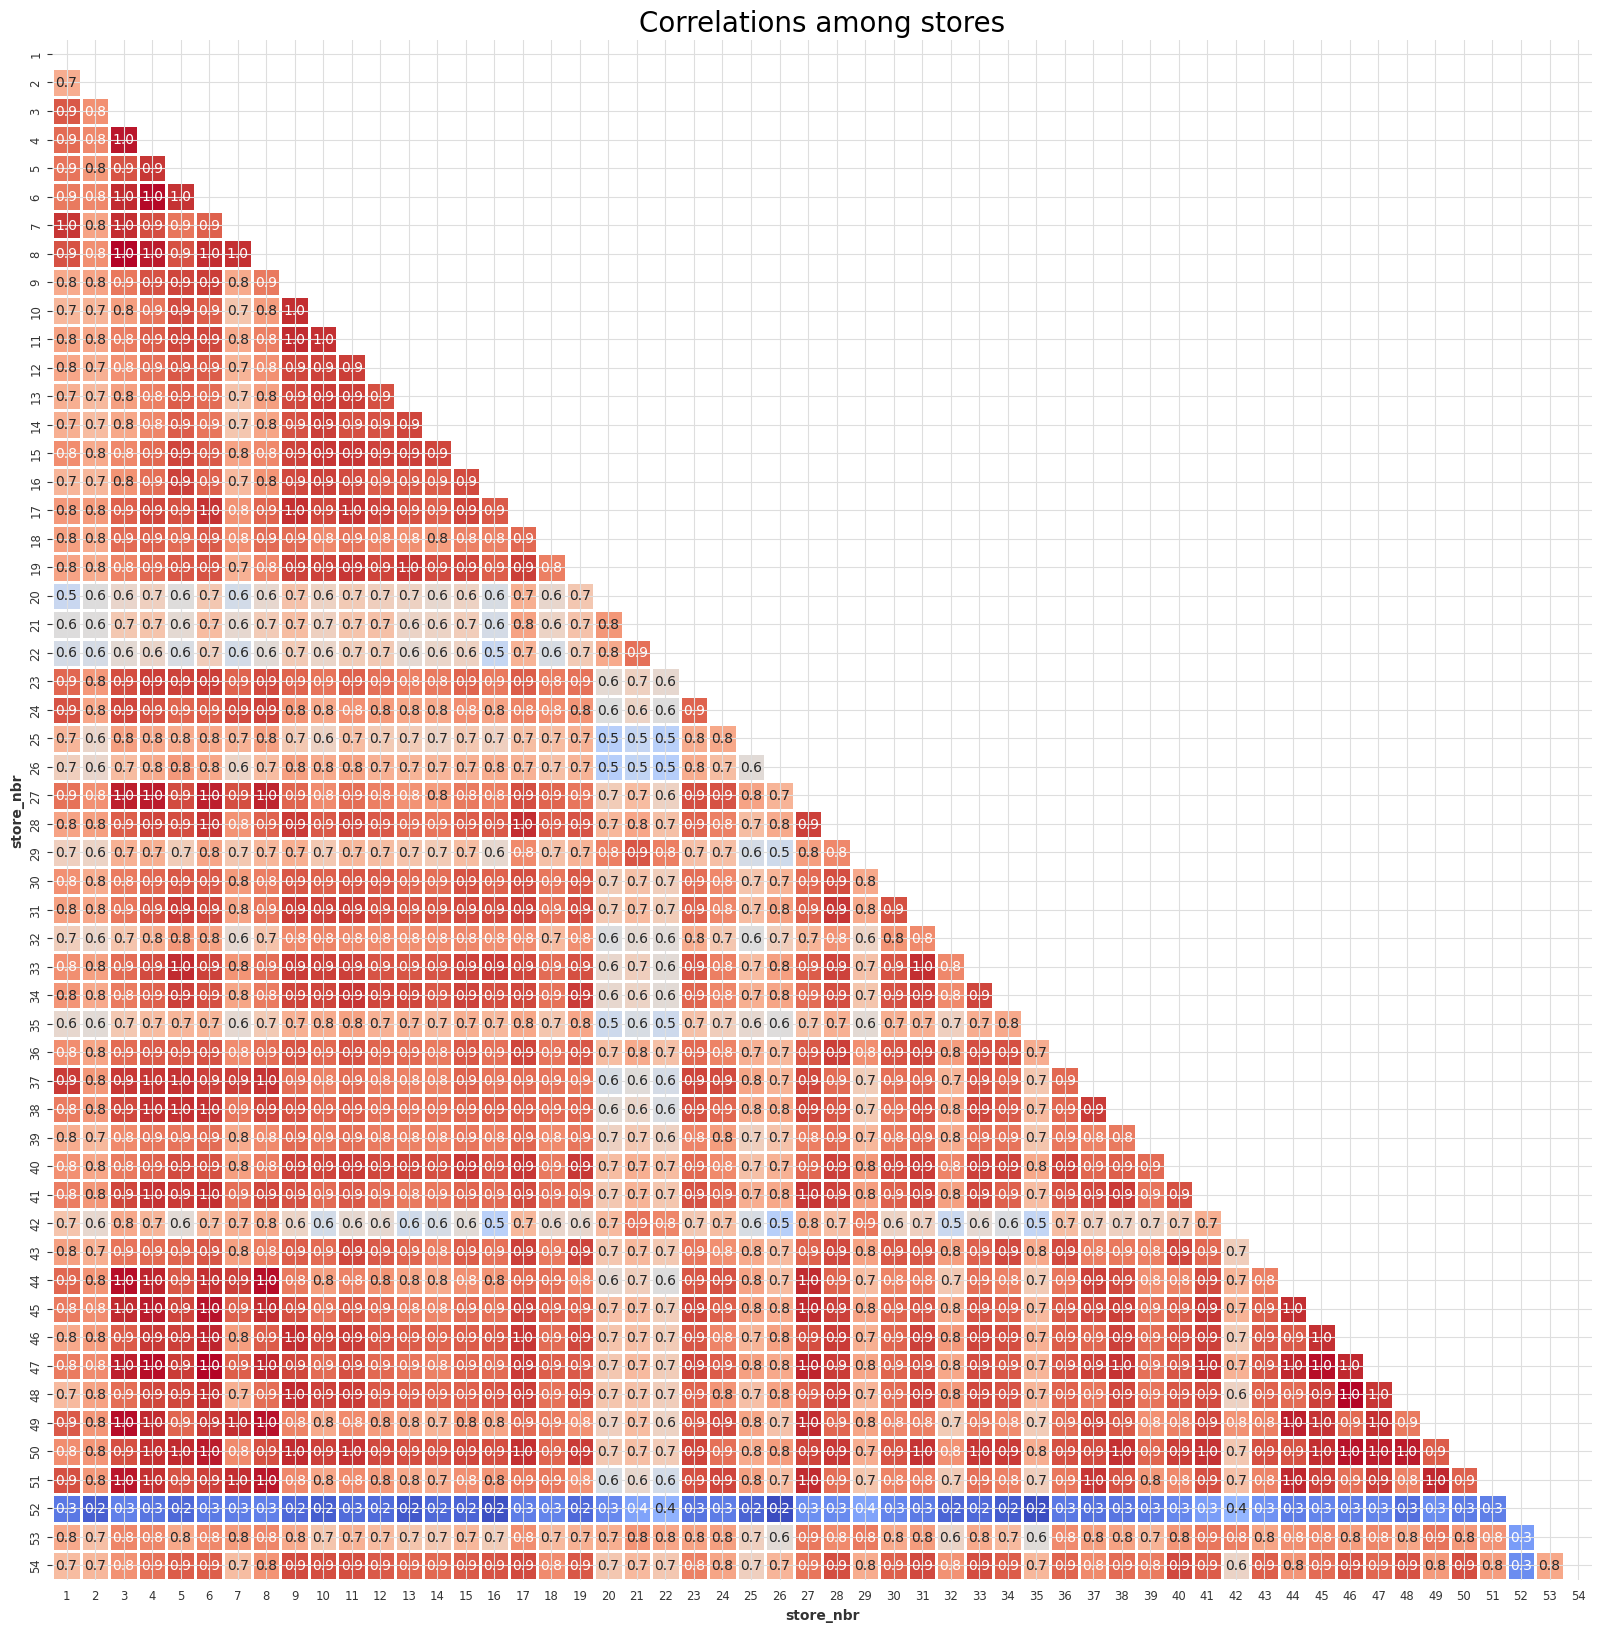

In [ ]:
%matplotlib inline
a = train[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

In [ ]:
import gc
print(train.shape)
# Anti Join
outer_join = train.merge(c[c.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
gc.collect()
train.shape

(3000888, 6)


(2911636, 6)

In [ ]:
# zero prediction
zero_prediction = []
for i in range(0,len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )
zero_prediction = pd.concat(zero_prediction)
del c
gc.collect()
zero_prediction

date  store_nbr           family  sales
0  2017-08-16          1        BABY CARE      0
1  2017-08-17          1        BABY CARE      0
2  2017-08-18          1        BABY CARE      0
3  2017-08-19          1        BABY CARE      0
4  2017-08-20          1        BABY CARE      0
..        ...        ...              ...    ...
11 2017-08-27         54  LAWN AND GARDEN      0
12 2017-08-28         54  LAWN AND GARDEN      0
13 2017-08-29         54  LAWN AND GARDEN      0
14 2017-08-30         54  LAWN AND GARDEN      0
15 2017-08-31         54  LAWN AND GARDEN      0

[848 rows x 4 columns]

In [ ]:
a = train.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "family", title = "Daily total sales of the family")

In [ ]:
a = train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")

In [ ]:
d = pd.merge(train, stores)
d["store_nbr"] = d["store_nbr"].astype("int8")
d["year"] = d.date.dt.year
px.line(d.groupby(["city", "year"]).sales.mean().reset_index(), x = "year", y = "sales", color = "city")

In [ ]:
holidays = holidays_events_df.copy()
holidays["date"] = pd.to_datetime(holidays.date)

# holidays[holidays.type == "Holiday"]
# holidays[(holidays.type == "Holiday") & (holidays.transferred == True)]

# Transferred Holidays
tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(tr).reset_index(drop = True)


# Additional Holidays
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Bridge Holidays
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

 
# Work Day Holidays, that is meant to payback the Bridge.
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]  


# Split

# Events are national
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()



d = pd.merge(train.append(test), stores)
d["store_nbr"] = d["store_nbr"].astype("int8")


# National Holidays & Events
#d = pd.merge(d, events, how = "left")
d = pd.merge(d, national, how = "left")
# Regional
d = pd.merge(d, regional, how = "left", on = ["date", "state"])
# Local
d = pd.merge(d, local, how = "left", on = ["date", "city"])

# Work Day: It will be removed when real work day colum created
d = pd.merge(d,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

# EVENTS
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

events, events_cat = one_hot_encoder(events, nan_as_category=False)
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

d = pd.merge(d, events, how = "left")
d[events_cat] = d[events_cat].fillna(0)

# New features
d["holiday_national_binary"] = np.where(d.holiday_national.notnull(), 1, 0)
d["holiday_local_binary"] = np.where(d.holiday_local.notnull(), 1, 0)
d["holiday_regional_binary"] = np.where(d.holiday_regional.notnull(), 1, 0)

# 
d["national_independence"] = np.where(d.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
d["local_cantonizacio"] = np.where(d.holiday_local.str.contains("Cantonizacio"), 1, 0)
d["local_fundacion"] = np.where(d.holiday_local.str.contains("Fundacion"), 1, 0)
d["local_independencia"] = np.where(d.holiday_local.str.contains("Independencia"), 1, 0)


holidays, holidays_cat = one_hot_encoder(d[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
d = pd.concat([d.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

he_cols = d.columns[d.columns.str.startswith("events")].tolist() + d.columns[d.columns.str.startswith("holiday")].tolist() + d.columns[d.columns.str.startswith("national")].tolist()+ d.columns[d.columns.str.startswith("local")].tolist()
d[he_cols] = d[he_cols].astype("int8")

d[["family", "city", "state", "type"]] = d[["family", "city", "state", "type"]].astype("category")

del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
gc.collect()

d.head(10)


<ipython-input-21-809b18410e13>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-21-809b18410e13>:18: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

<ipython-input-21-809b18410e13>:18: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-21-809b18410e13>:43: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



id       date  store_nbr      family  sales  onpromotion   city  \
0      0 2013-01-01          1  AUTOMOTIVE    0.0          0.0  Quito   
1   1782 2013-01-02          1  AUTOMOTIVE    2.0          0.0  Quito   
2   3564 2013-01-03          1  AUTOMOTIVE    3.0          0.0  Quito   
3   5346 2013-01-04          1  AUTOMOTIVE    3.0          0.0  Quito   
4   7128 2013-01-05          1  AUTOMOTIVE    5.0          0.0  Quito   
5   8910 2013-01-06          1  AUTOMOTIVE    2.0          0.0  Quito   
6  10692 2013-01-07          1  AUTOMOTIVE    0.0          0.0  Quito   
7  12474 2013-01-08          1  AUTOMOTIVE    2.0          0.0  Quito   
8  14256 2013-01-09          1  AUTOMOTIVE    2.0          0.0  Quito   
9  16038 2013-01-10          1  AUTOMOTIVE    2.0          0.0  Quito   

       state type  cluster  ... holiday_local_Fundacion_de_Ibarra  \
0  Pichincha    D       13  ...                                 0   
1  Pichincha    D       13  ...                                 0   
2  Pichincha    D       13  ...                                 0   
3  Pichincha    D       13  ...                                 0   
4  Pichincha    D       13  ...                                 0   
5  Pichincha    D       13  ...                                 0   
6  Pichincha    D       13  ...                                 0   
7  Pichincha    D       13  ...                                 0   
8  Pichincha    D       13  ...                                 0   
9  Pichincha    D       13  ...                                 0   

   holiday_local_Fundacion_de_Loja  holiday_local_Fundacion_de_Machala  \
0                                0                                   0   
1                                0                                   0   
2                                0                                   0   
3                                0                                   0   
4                                0                                   0   
5                                0                                   0   
6                                0                                   0   
7                                0                                   0   
8                                0                                   0   
9                                0                                   0   

   holiday_local_Fundacion_de_Manta  holiday_local_Fundacion_de_Quito  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   
5                                 0                                 0   
6                                 0                                 0   
7                                 0                                 0   
8                                 0                                 0   
9                                 0                                 0   

   holiday_local_Fundacion_de_Riobamba  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   
5                                    0   
6                                    0   
7                                    0   
8                                    0   
9                                    0   

   holiday_local_Fundacion_de_Santo_Domingo  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
5                                         0   
6                              

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

<ipython-input-22-5145353c8c4e>:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



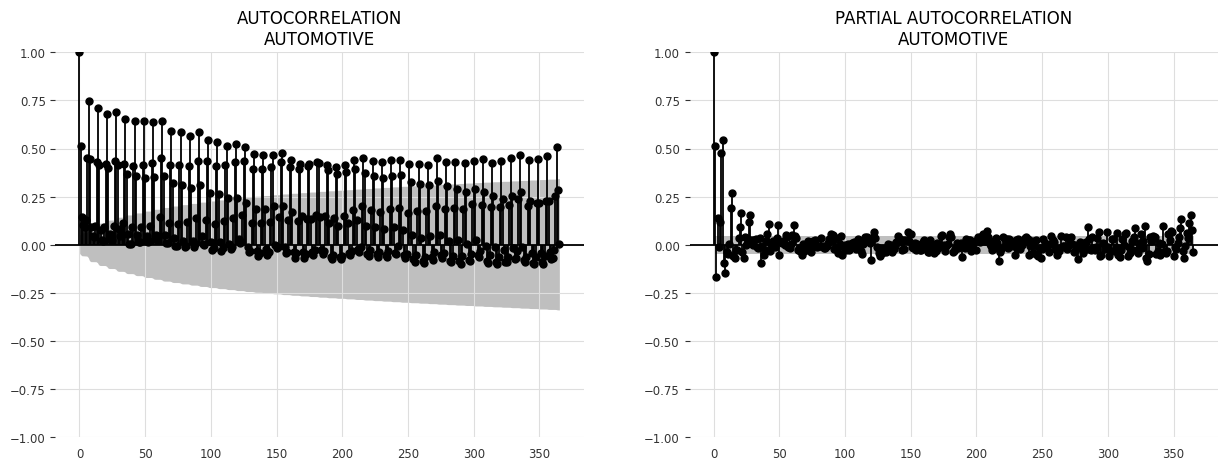

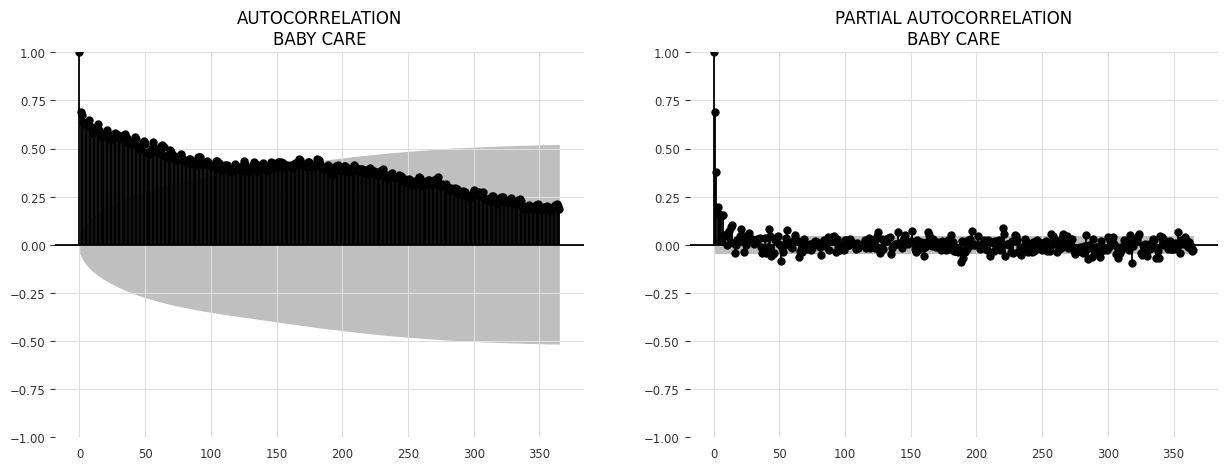

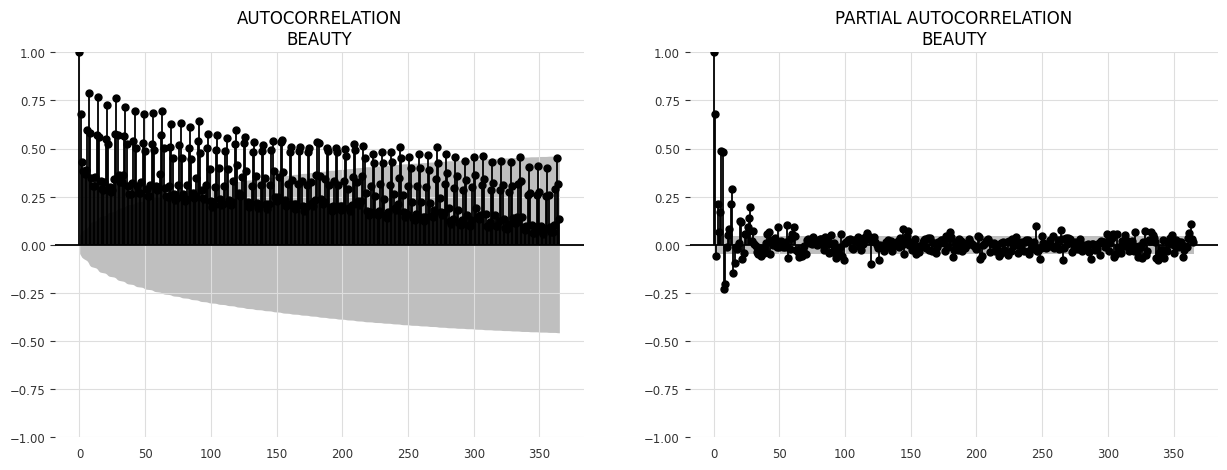

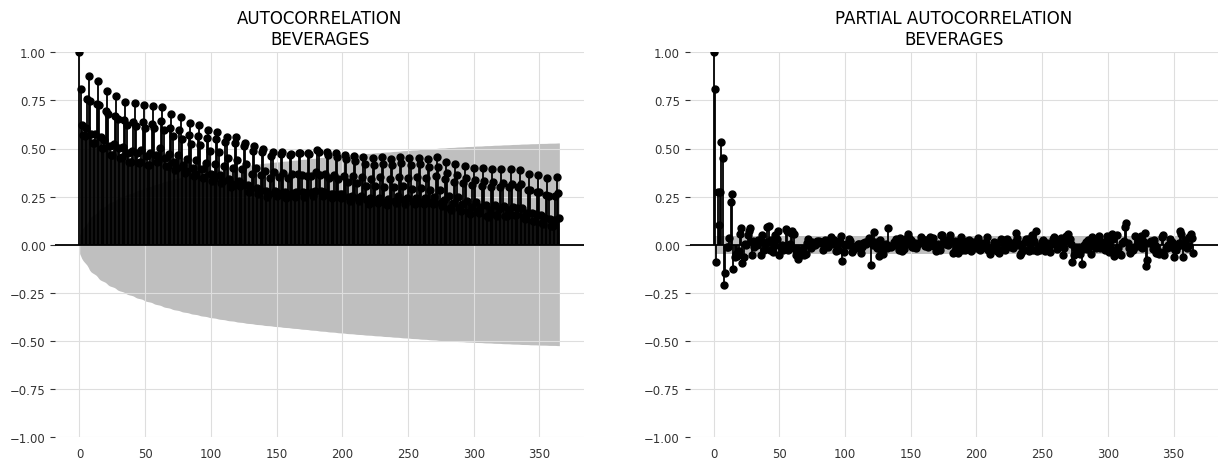

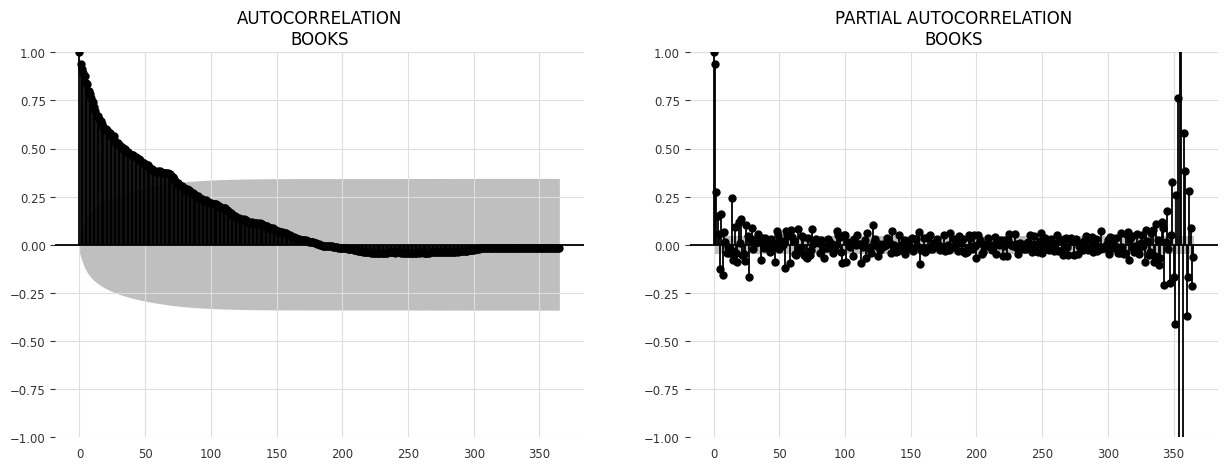

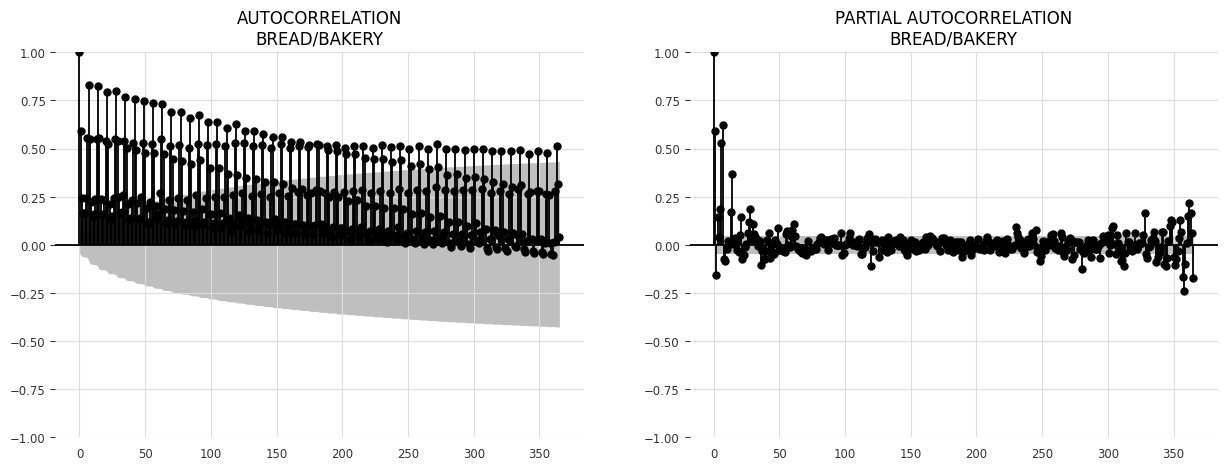

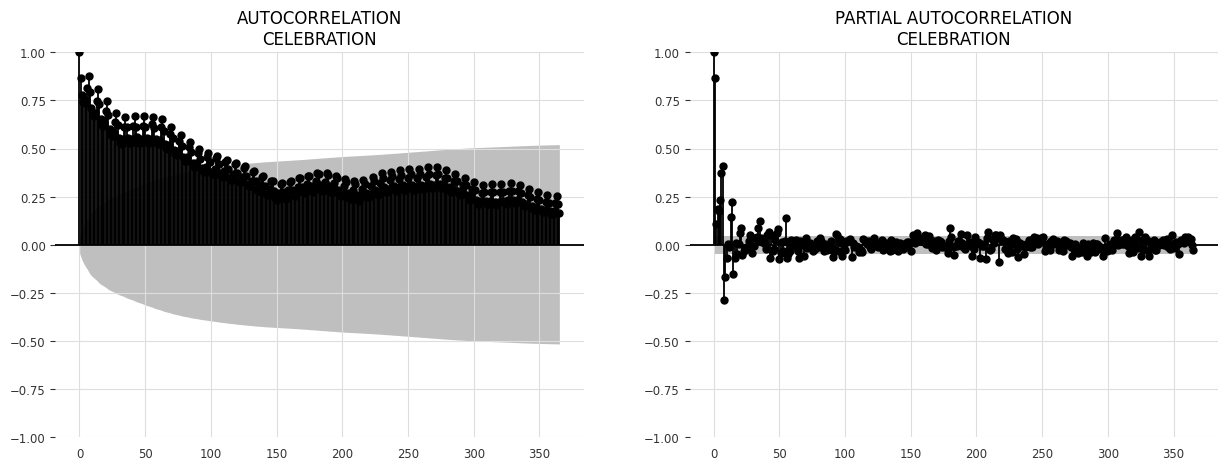

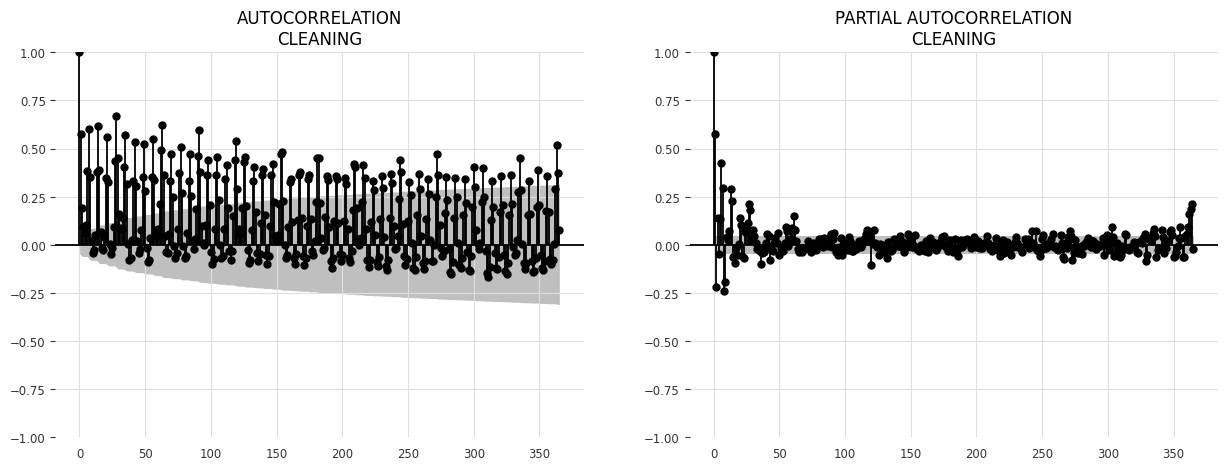

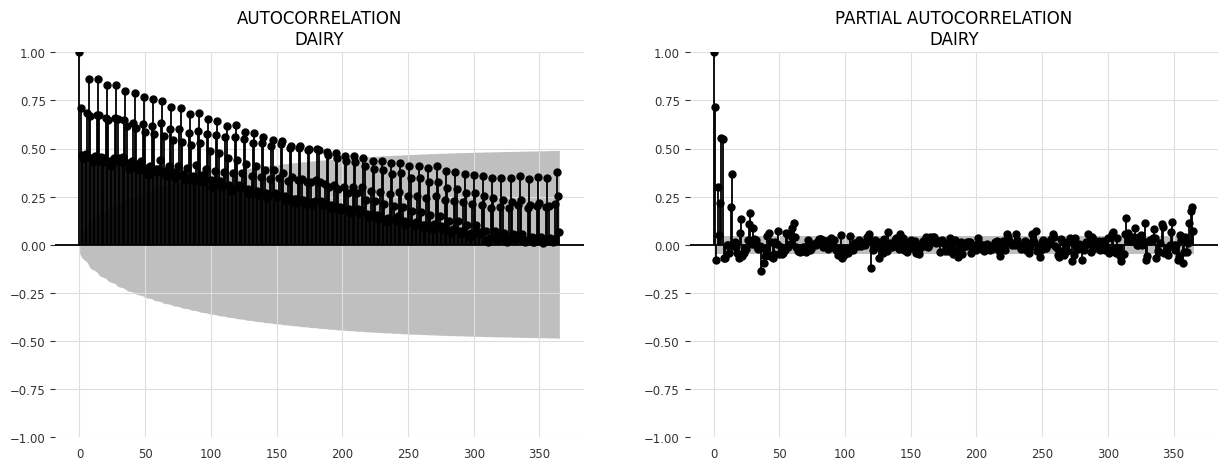

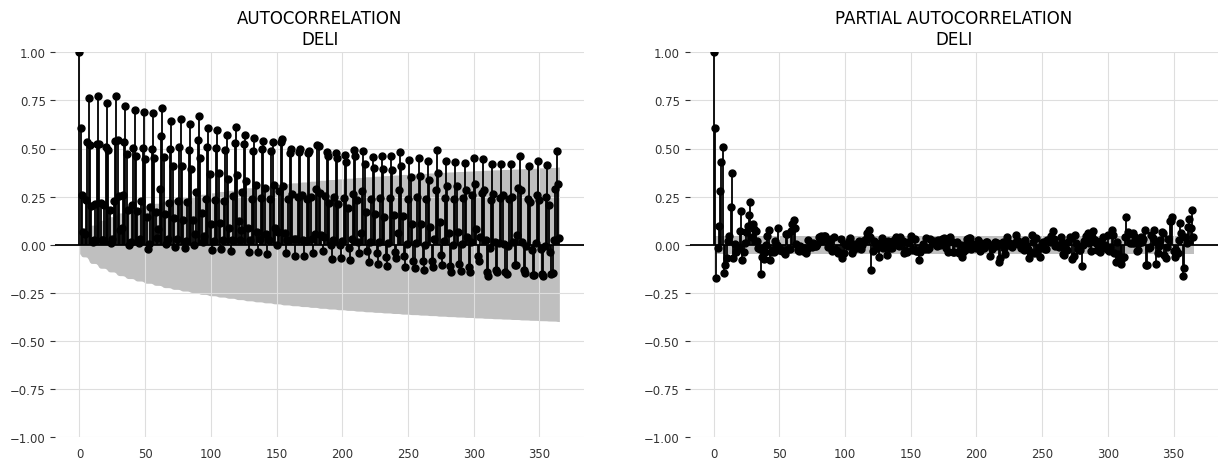

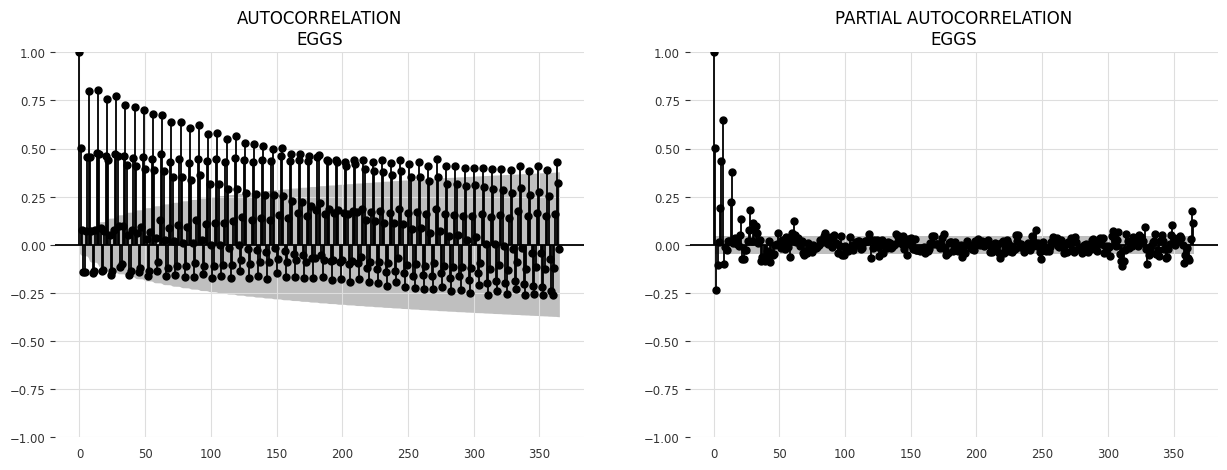

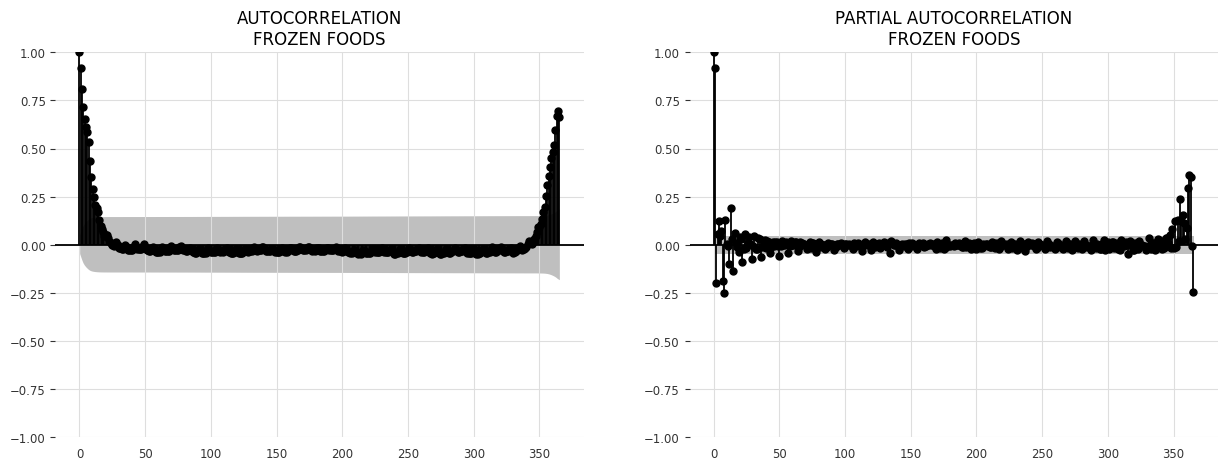

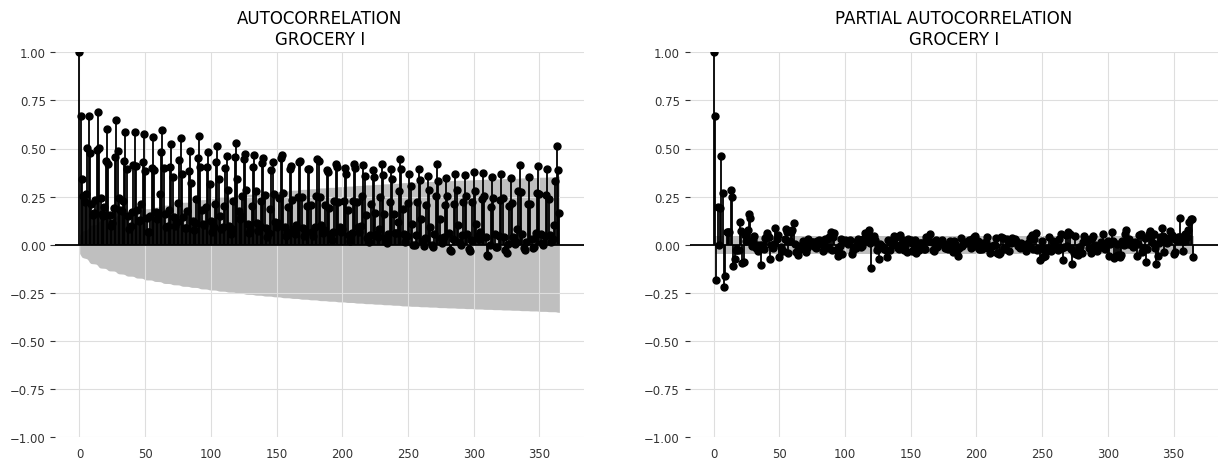

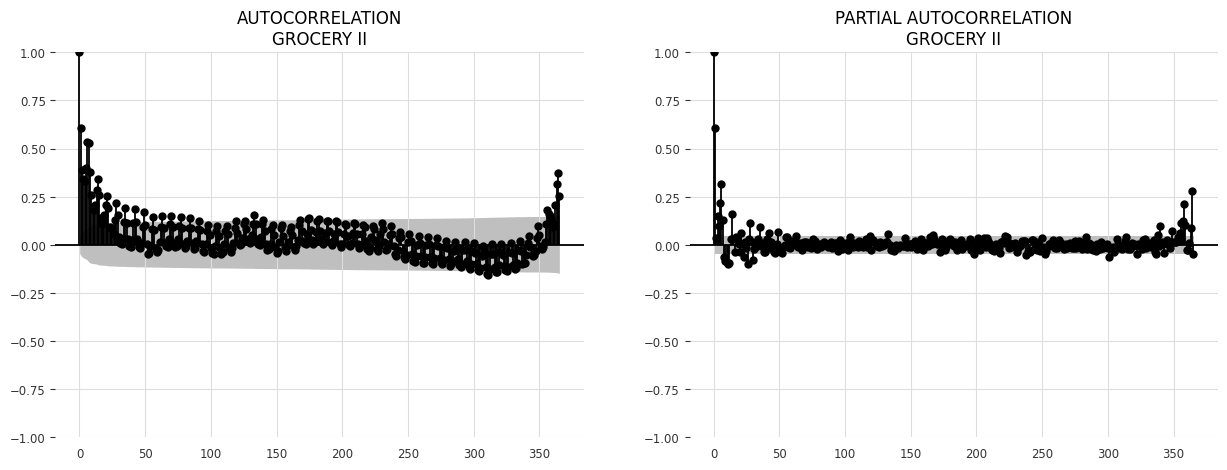

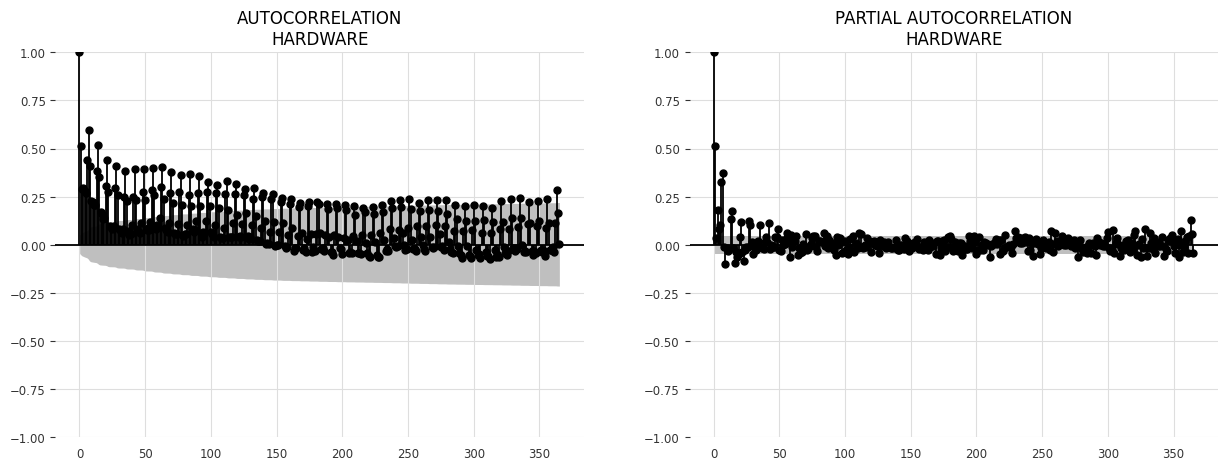

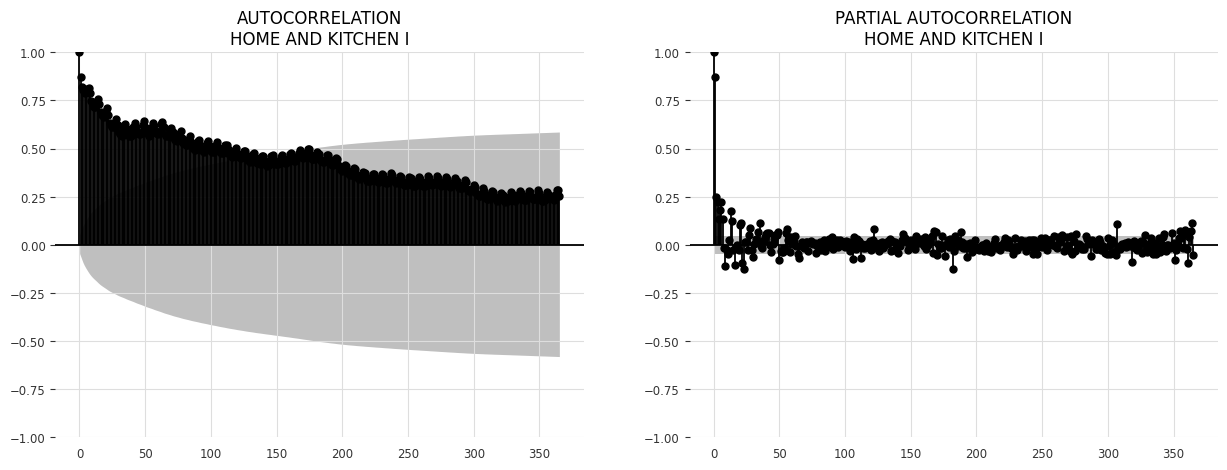

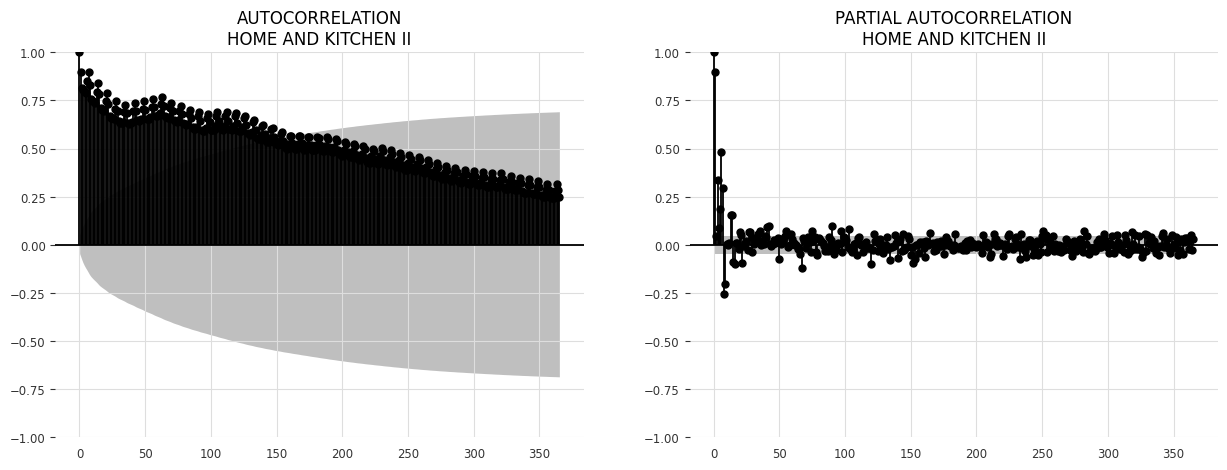

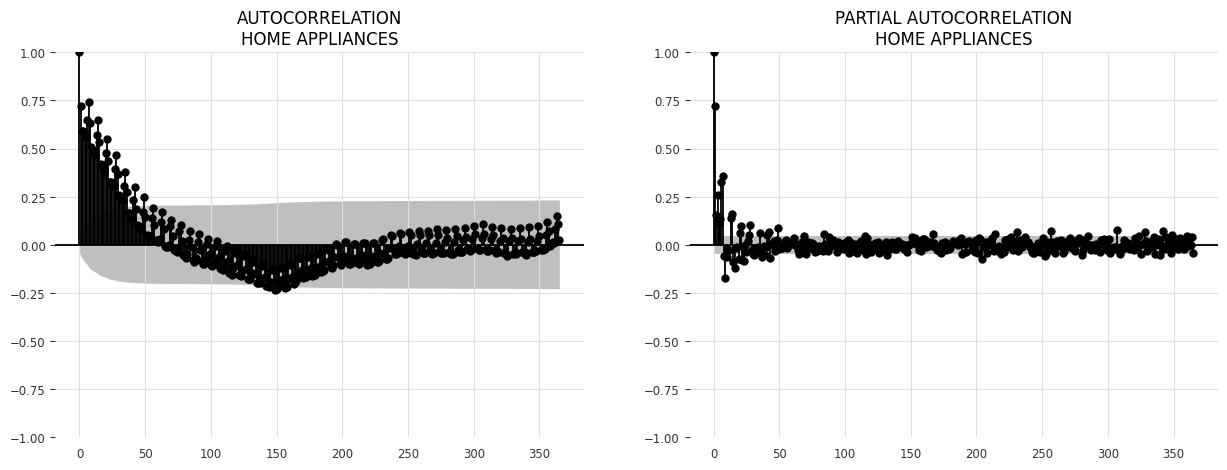

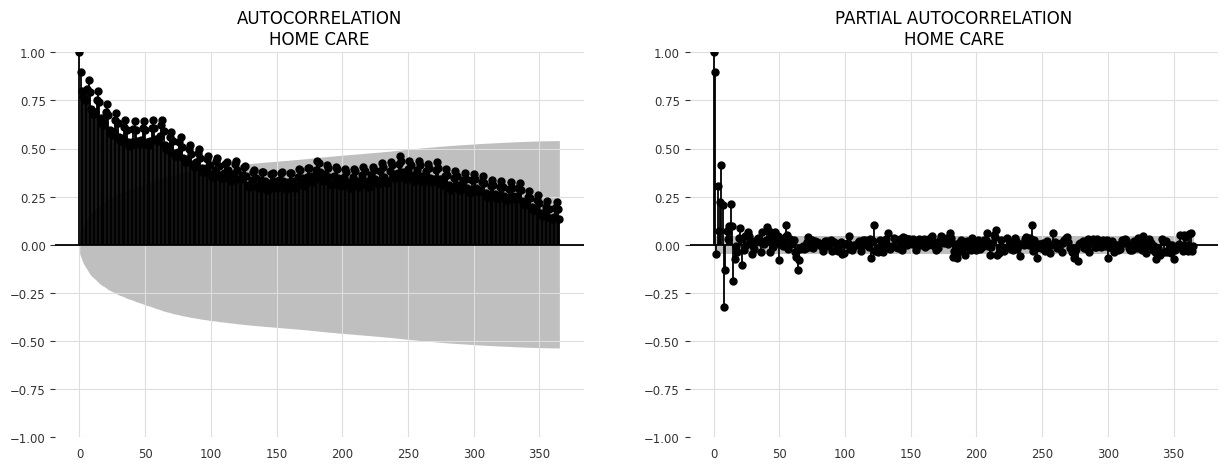

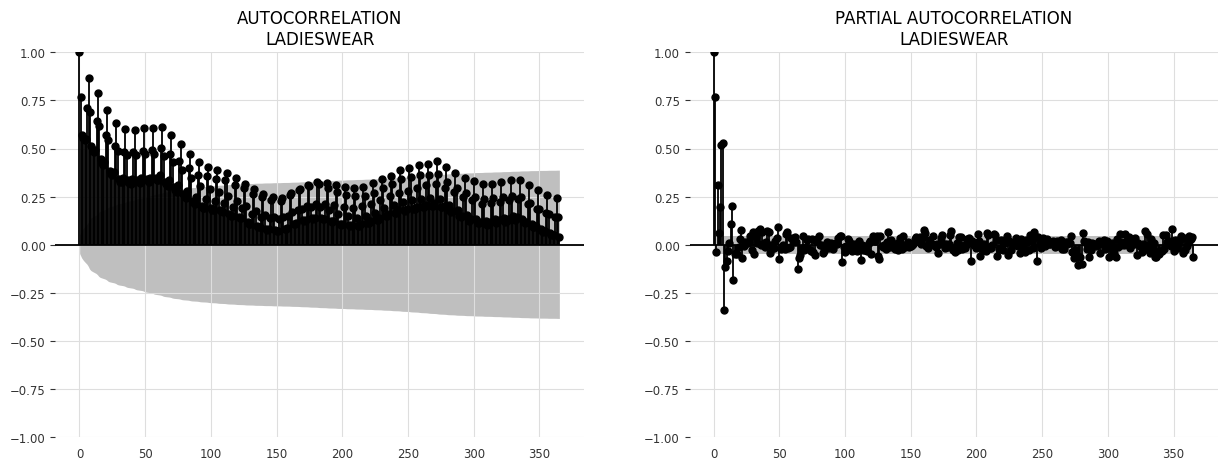

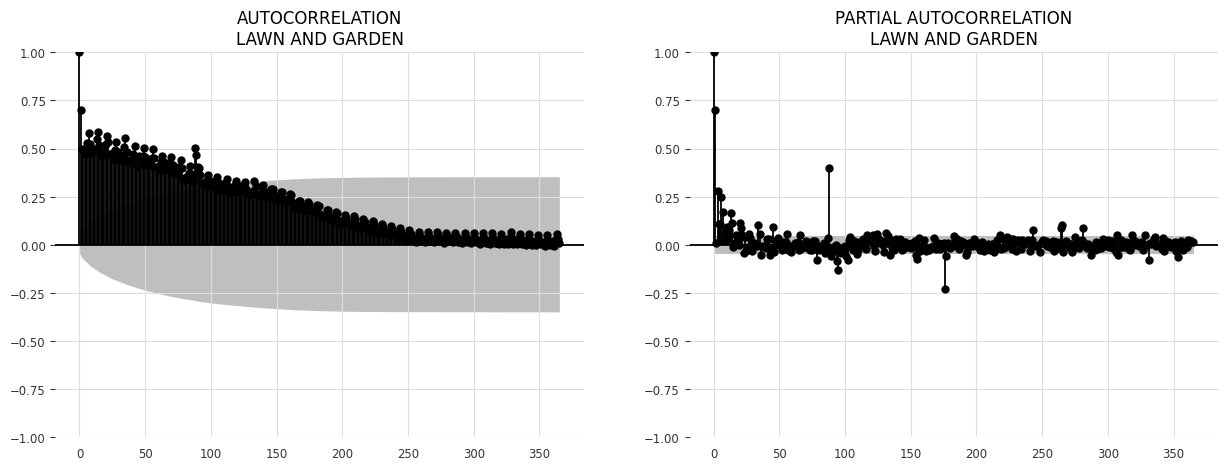

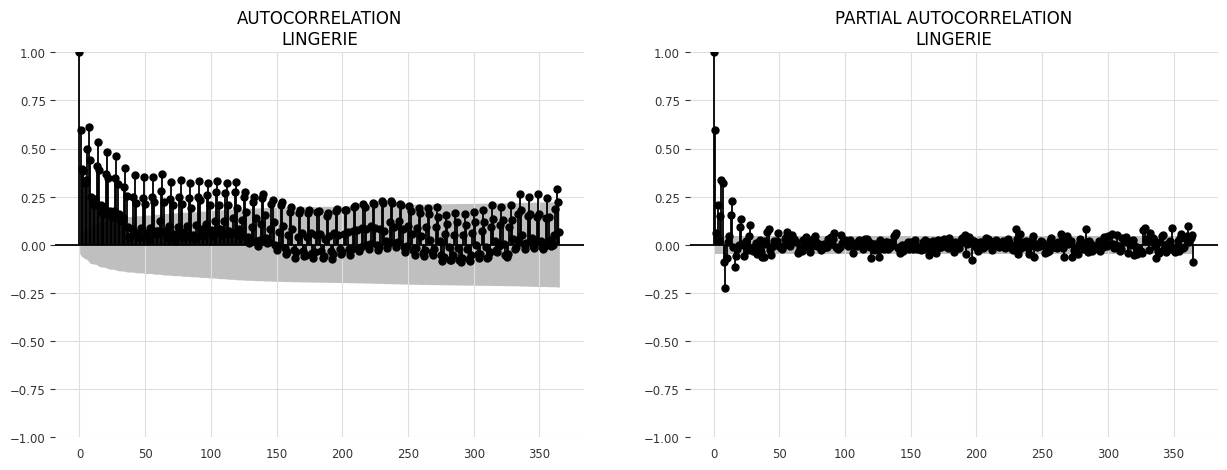

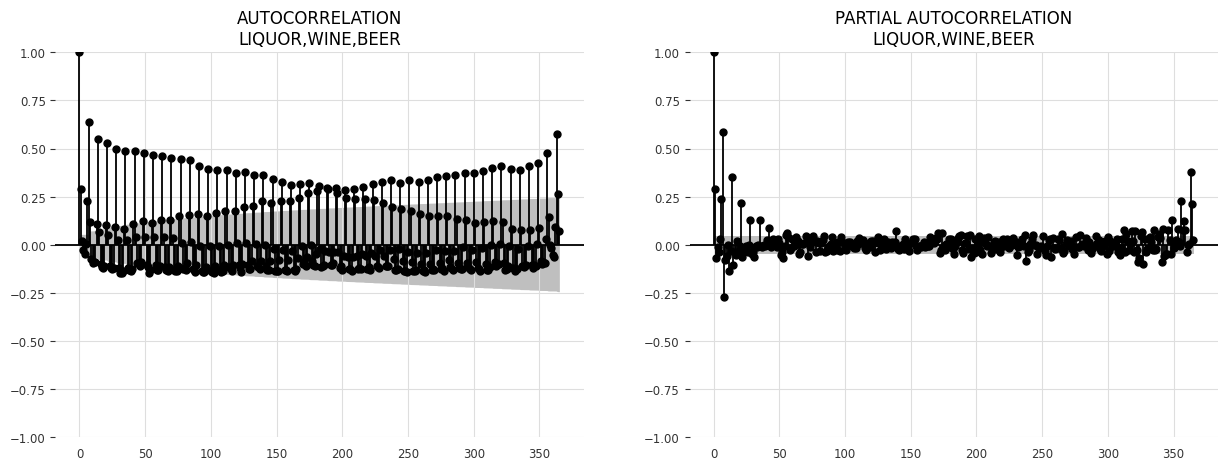

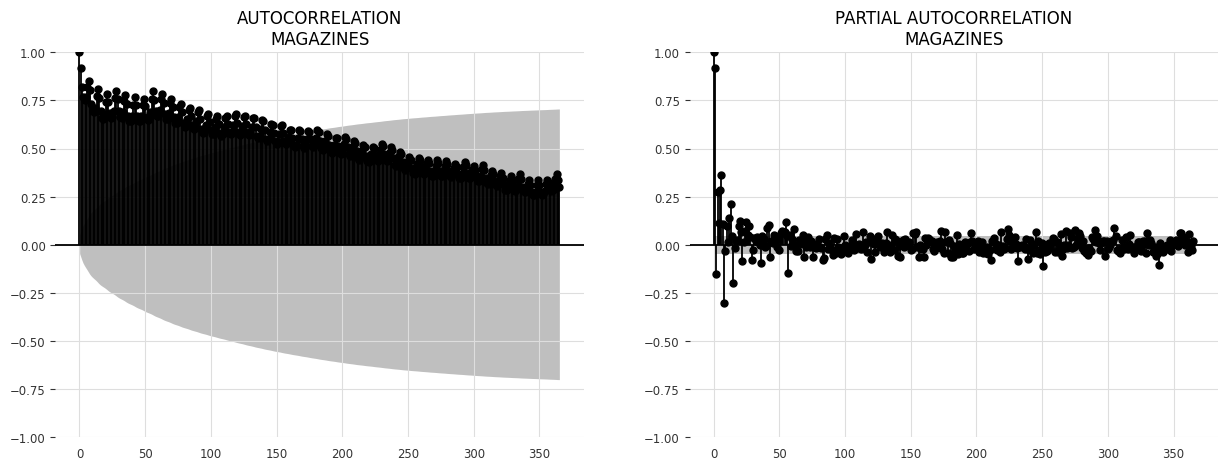

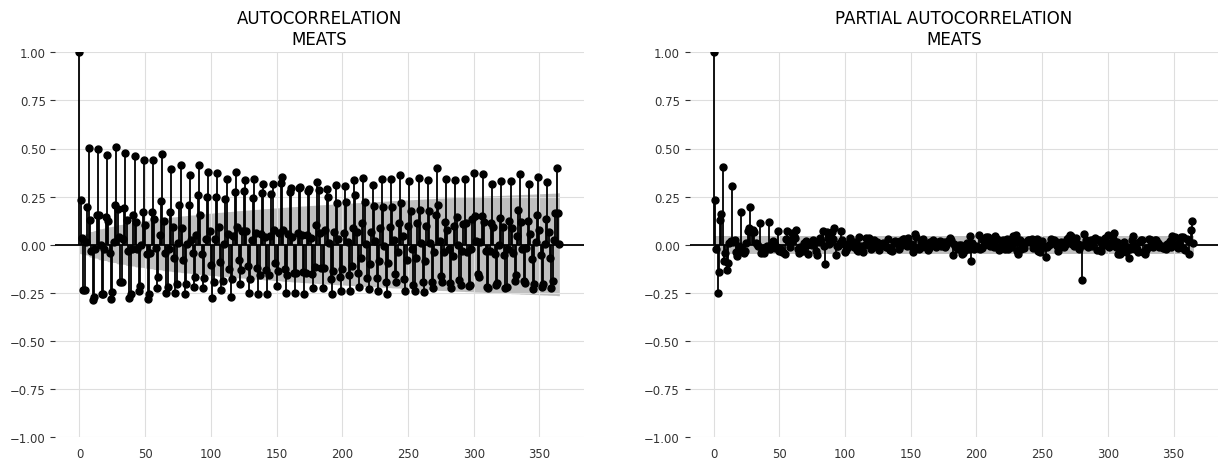

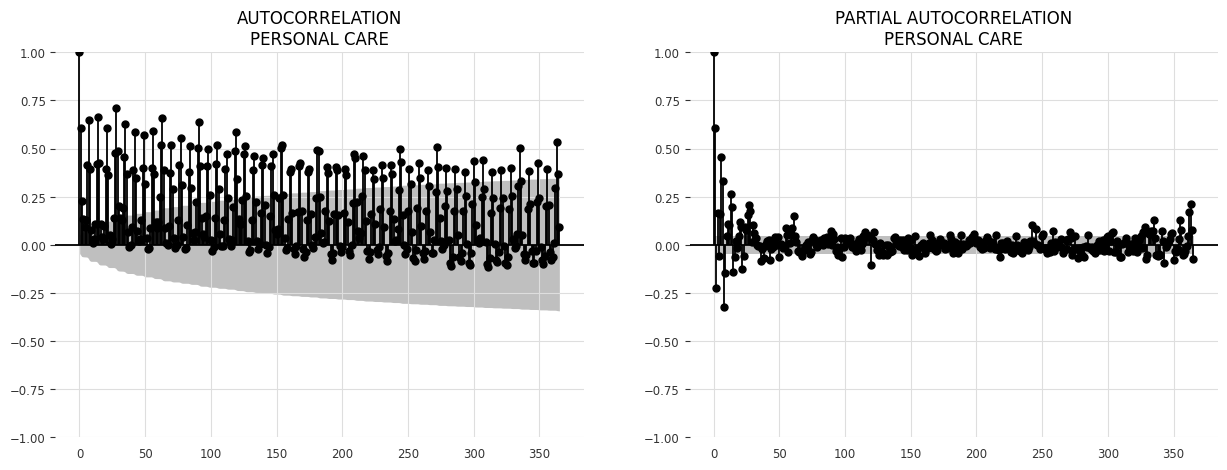

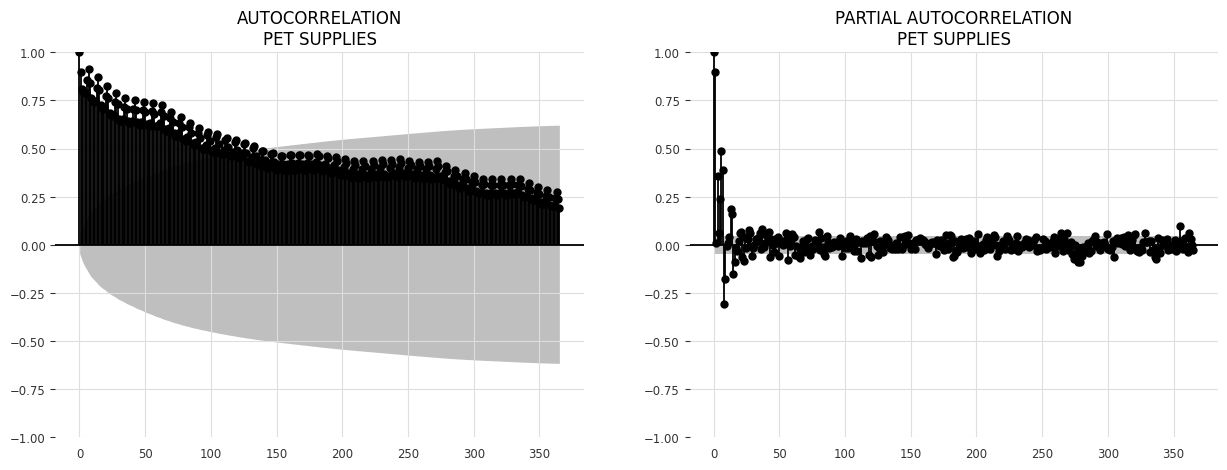

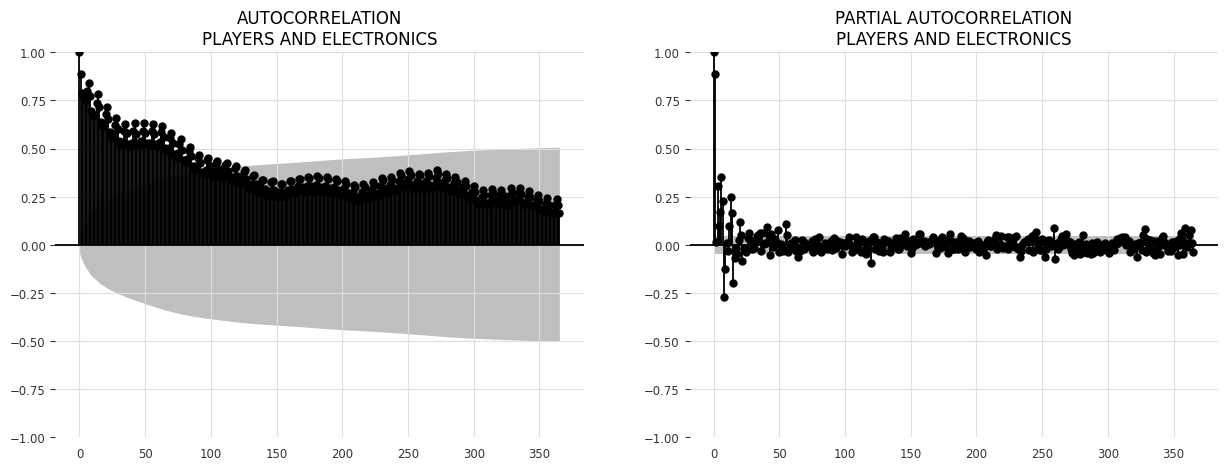

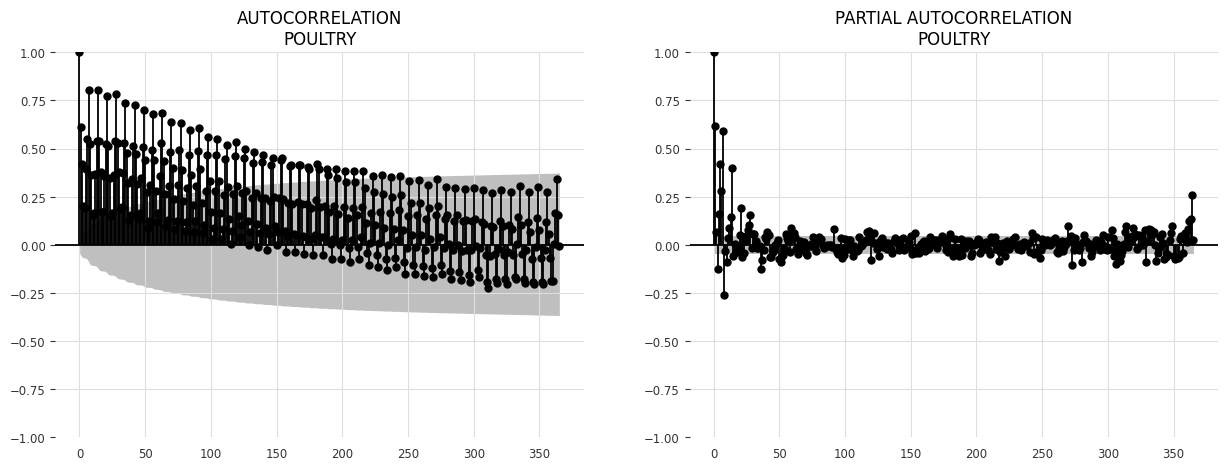

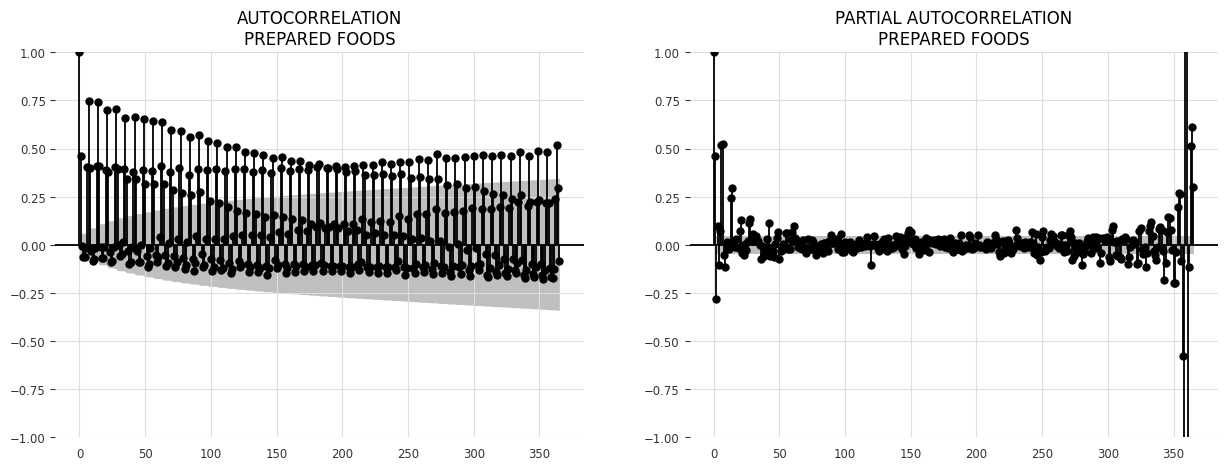

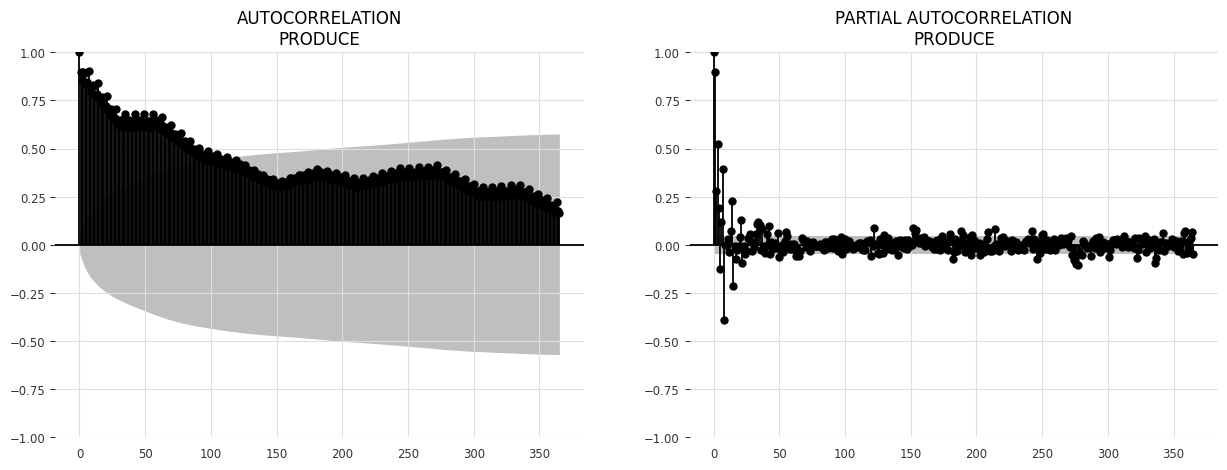

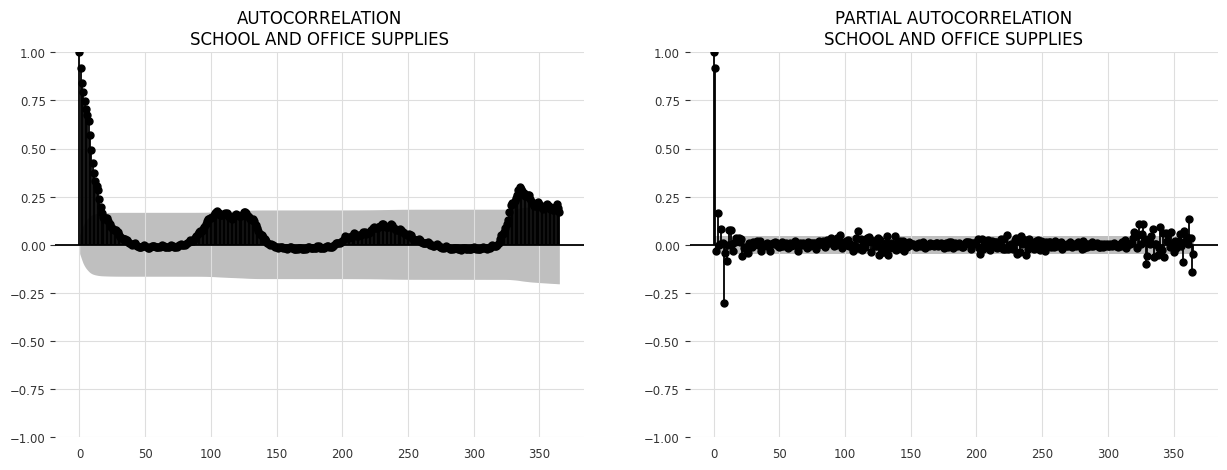

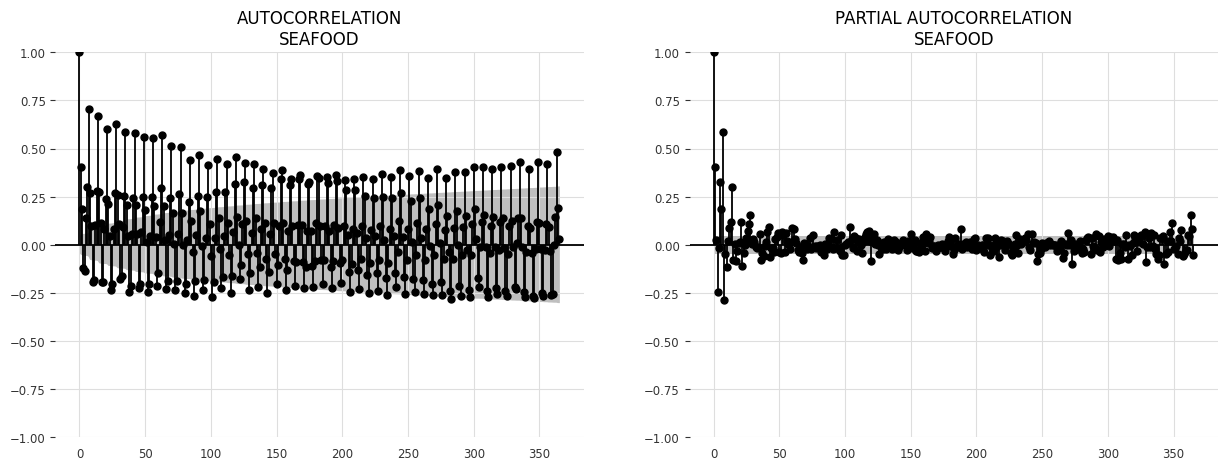

In [ ]:
import statsmodels.api as sm

#a = d[d["store_nbr"]==1].set_index("date")
a = d[(d.sales.notnull())].groupby(["date", "family"]).sales.mean().reset_index().set_index("date")
for num, i in enumerate(a.family.unique()):
    try:
        fig, ax = plt.subplots(1,2,figsize=(15,5))
        temp = a[(a.family == i)]#& (a.sales.notnull())
        sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[0], title = "AUTOCORRELATION\n" + i)
        sm.graphics.tsa.plot_pacf(temp.sales, lags=365, ax=ax[1], title = "PARTIAL AUTOCORRELATION\n" + i)
    except:
        pass

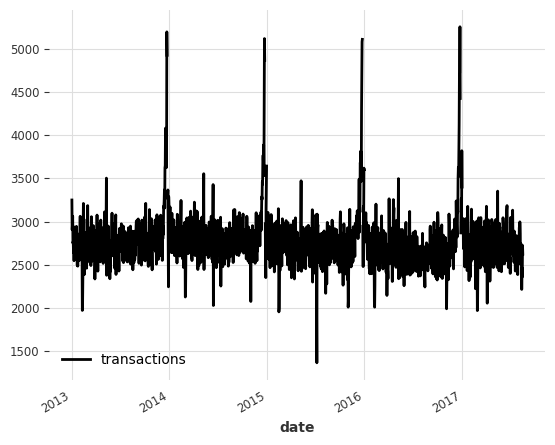

In [ ]:

transaction_ts = TimeSeries.from_group_dataframe(
                                transactions_df,
                                time_col="date",
                                group_cols="store_nbr",
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')

transaction_ts[7].plot()

##Visualizing the Data

we can plot the timeseries easily with `darts` and `matplotlib`. just sub the `family_TS_dct[NAME] : NAME` with the name of the family.

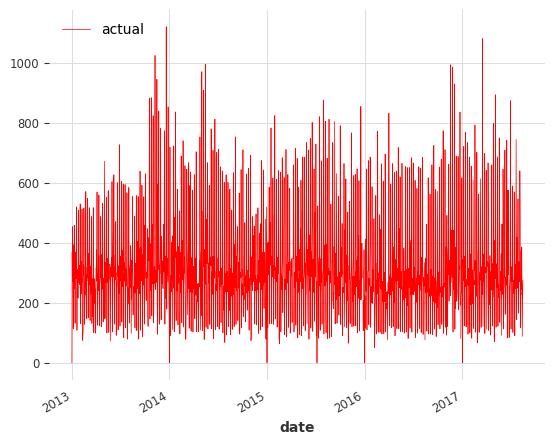

In [ ]:

from darts.dataprocessing.transformers import Scaler
transformer=Scaler()
plot_auto = transformer.fit_transform(family_TS_dict['PRODUCE'][7])
#help(plt.Line2D)
family_TS_dict['MEATS'][0].plot(label='actual',color='red', lw=0.5)

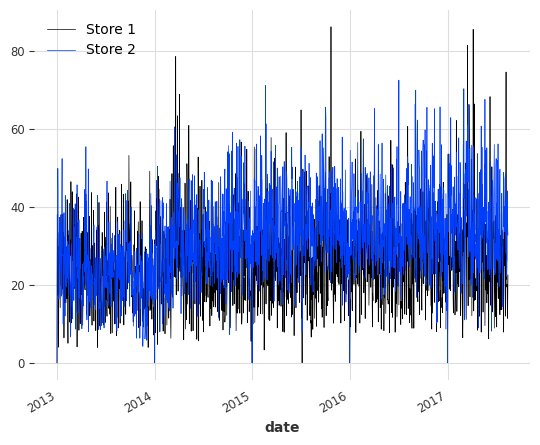

In [ ]:
ts = family_TS_dict['SEAFOOD']
selected_time_series = [ts[0], ts[1]]
for i, ts in enumerate(selected_time_series):
  ts.plot(label=f"Store {i+1}", lw=0.5,)

Let's look at the oil data, first change it into a TimeSeries

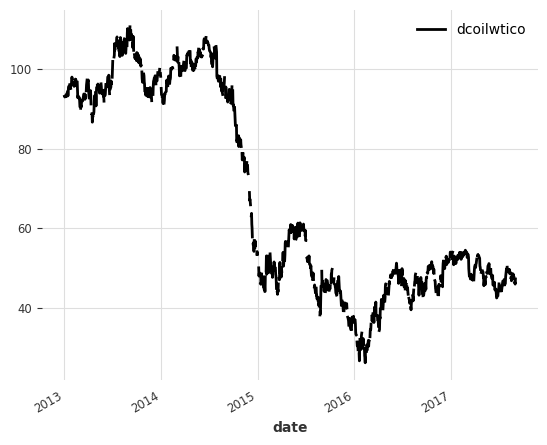

In [ ]:
oil_ts = TimeSeries.from_dataframe(oil_df, 
                                   time_col='date', 
                                   fill_missing_dates=True,
                                   freq='D'
                                   )
oil_ts.plot()

In [ ]:
holidays_events_df

date        type    locale locale_name  \
0    2012-03-02     Holiday     Local       Manta   
1    2012-04-01     Holiday  Regional    Cotopaxi   
2    2012-04-12     Holiday     Local      Cuenca   
3    2012-04-14     Holiday     Local    Libertad   
4    2012-04-21     Holiday     Local    Riobamba   
..          ...         ...       ...         ...   
345  2017-12-22  Additional  National     Ecuador   
346  2017-12-23  Additional  National     Ecuador   
347  2017-12-24  Additional  National     Ecuador   
348  2017-12-25     Holiday  National     Ecuador   
349  2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

## Features

There are a lot of factors here. should we train one regression model, multiple models, one for each family? we should decide how to best be able to forcast the prices.

I think we should start simple, just looking at a feature or two and then incorperate more variables to increase our performance if we can ge something running/.


*How can we incorperate covariates into the projections?*

### Models:
use `sklearn` or `sktime` or `darts` 

* Todo: build a few regression models, starting with simplest 
* tune hyperparameter `GridSearch or RandomSearch` 

**Darts has methods for exponential smoothing, and some other things. They're basically trying to be sklearn for forecasting


In [ ]:
# Simple Exponential Smoothing model

import numpy as np
import pandas as pd
import os

!pip install darts --quiet
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Theta
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build 

In [ ]:
# Renaming my variables so they don't interfere with anybody else's models
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
oil_data = pd.read_csv('oil.csv')

# This shows we only have 1684 unique values when we should have 1688
len(train_data['date'].unique())

360

In [ ]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

# Using an arbitrary store number and family to check for missing values
check = train_data[(train_data['store_nbr'] == 8) & (train_data['family'] == 'AUTOMOTIVE')]
check = check.reset_index(drop=True)

# Checking for missing dates, values align to Dec 25 each year
count = 0
for i in range(1, 1685):
    if check['date'][i] - check['date'][i - 1] != timedelta(days=1):
        print(i)
        count += 1
    if count == 4:
        break

KeyError: ignored

In [ ]:
# Actual code for ES model using DARTS

forecast = pd.DataFrame()

for store in set(train_data['store_nbr'].unique()):
     for family in train_data['family'].unique():

         series = train_data[(train_data['store_nbr'] == store) & (train_data['family'] == family)]
        
        # December 25 always has 0 sales
         rows = [{'date': datetime(i, 12, 25), 'sales': 0} for i in range(2016, 2017)]
         series = series.append(rows, ignore_index=True)
         series.sort_values(by=['date'], ignore_index=True, inplace=True)
         series = TimeSeries.from_dataframe(series, 'date', 'sales',fill_missing_dates=True, freq=None)
         
        # Prediction for next 16 days
         model = ARIMA()
         model.fit(series)
         prediction = model.predict(16)
         prediction = prediction.pd_dataframe()
        
         target = test_data[(test_data['store_nbr'] == store) & (test_data['family'] == family)]
         target['sales'] = np.array(prediction['sales'])
        
         forecast = pd.concat([forecast, target])

forecast.sort_index(inplace=True)

# Score obtained from Kaggle for this model was 0.43496

ERROR:darts.timeseries:ValueError: Input time series must be of (length>=3) when fill_missing_dates=True and freq=None.


ValueError: ignored

In [ ]:
# Functions that I used to print output of ES forecast to submission document
 output = forecast[['id', 'sales']]
 output.to_csv('submission.csv', index=False)

# Plotting function for result
 series.plot()

In [ ]:
 !pip install -q scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

from darts.models import RandomForest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 81.3 MB/s eta 0:00:00


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
# Actual code for ES model using DARTS
from tqdm import tqdm
from darts.models import ARIMA
forecast = pd.DataFrame()

for store in tqdm(set(train_data['store_nbr'].unique())):
    for family in tqdm(train_data['family'].unique()):

         series = train_data[(train_data['store_nbr'] == store) & (train_data['family'] == family)]
        
        # December 25 always has 0 sales
         rows = [{'date': datetime(i, 12, 25), 'sales': 0} for i in range(2016, 2017)]
         series = series.append(rows, ignore_index=True)
         series.sort_values(by=['date'], ignore_index=True, inplace=True)
         series = TimeSeries.from_dataframe(series, 'date', 'sales',fill_missing_dates=True, freq=None)
         
        # Prediction for next 16 days
         model = RandomForest(max_depth=5,
                              lags = 30,
                              n_estimators = 25)
         model.fit(series)
         prediction = model.predict(16)
         prediction = prediction.pd_dataframe()
        
         target = test_data[(test_data['store_nbr'] == store) & (test_data['family'] == family)]
         target['sales'] = np.array(prediction['sales'])
        
         forecast = pd.concat([forecast, target])
    series.plot()
plt.legend()
forecast.sort_index(inplace=True)
# Score obtained from Kaggle for this model was 0.43206

  0%|          | 0/54 [00:00<?, ?it/s]


ValueError: ignored

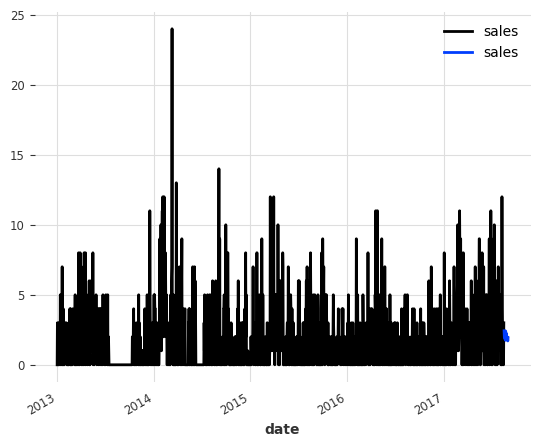

In [ ]:
# Functions that I used to print output of ES forecast to submission document
output = forecast[['id', 'sales']]
output.to_csv('submission2.csv', index=False)

# Plotting function for result
prediction = model.predict(16)


series.plot())
prediction.plot()
plt.legend()
##

Use the following code to generate a simple graph of predicted daily sales by family

In [ ]:
# Not all packages are involved in generating these graphs, this is just extra stuff from me messing around
import numpy as np
import pandas as pd
import os
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
oil_data = pd.read_csv('oil.csv')

In [ ]:
# Replace example.csv with the name of desired csv for graphing, will have to upload from computer to google drive for it to work
graph = pd.read_csv('submission.csv')

In [ ]:
test_graph = pd.merge(test_data, graph, how='left', on='id')
test_graph['date'] = pd.to_datetime(test_graph['date'])

In [ ]:
a = test_graph.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "family", title = "Predicted daily sales by family for Random Forest")